#  Import libraries

In [1]:
 # importovanie knižníc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

!pip install tensorflow
!pip install keras
!pip install imblearn

!pip install pyjanitor
import janitor

# Load Data

In [2]:
# nacitanie udajov do pomocou dataframeu do premennej
df = pd.read_csv('projekt-dataset.csv').clean_names()
pd.set_option('display.float_format','{:.2f}'.format)

df.head()

,bankrupt_,_roa_c_before_interest_and_depreciation_before_interest,_roa_a_before_interest_and_%_after_tax,_roa_b_before_interest_and_depreciation_after_tax,_operating_gross_margin,_realized_sales_gross_margin,_operating_profit_rate,_pre_tax_net_interest_rate,_after_tax_net_interest_rate,_non_industry_income_and_expenditure_revenue,...,_net_income_to_total_assets,_total_assets_to_gnp_price,_no_credit_interval,_gross_profit_to_sales,_net_income_to_stockholders_equity,_liability_to_equity,_degree_of_financial_leverage_dfl_,_interest_coverage_ratio_interest_expense_to_ebit_,_net_income_flag,_equity_to_liability
0,1,0.37,0.42,0.41,0.60,0.60,1.00,0.80,0.81,0.30,...,0.72,0.01,0.62,0.60,0.83,0.29,0.03,0.56,1,0.02
1,1,0.46,0.54,0.52,0.61,0.61,1.00,0.80,0.81,0.30,...,0.80,0.01,0.62,0.61,0.84,0.28,0.26,0.57,1,0.02
2,1,0.43,0.50,0.47,0.60,0.60,1.00,0.80,0.81,0.30,...,0.77,0.04,0.62,0.60,0.84,0.29,0.03,0.56,1,0.02
3,1,0.40,0.45,0.46,0.58,0.58,1.00,0.80,0.81,0.30,...,0.74,0.00,0.62,0.58,0.83,0.28,0.03,0.56,1,0.02
4,1,0.47,0.54,0.52,0.60,0.60,1.00,0.80,0.81,0.30,...,0.80,0.00,0.62,0.60,0.84,0.28,0.02,0.58,1,0.04


In [19]:
# nacitanie udajov z dataframu do premennych
y = df['bankrupt_']
x = df.drop('bankrupt_',axis=1)

Text(0.5, 1.0, 'Target feature - Bankrupt?')

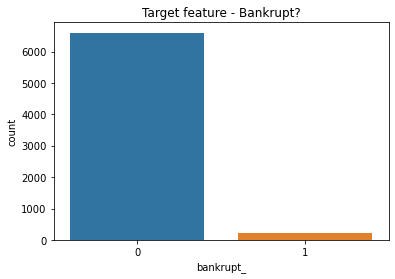

In [4]:
sns.countplot(x=df['bankrupt_'])
plt.title('Target feature - Bankrupt?')

(13198, 95)


Text(0.5, 1.0, 'After using OVERSAMPLING')

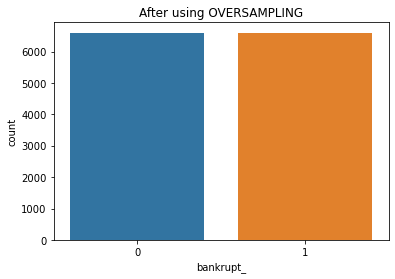

In [18]:
# najlepsie vysledky dosiahneme pomocou OVERSAMPLINGU cize dorovnanim hodnot X a Y
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x,y=oversample.fit_resample(x,y)
print(x.shape)
sns.countplot(x=y)
plt.title('After using OVERSAMPLING')

# Splitting and setting up model

In [6]:
# StandarScaler transformuje X-ove hodnoty  tak aby stredova hodnota bola 0 a standardna odchylka 1
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_scale=scaler.fit_transform(x)

In [15]:
# Importovanie kniznic pre neuronovu siet
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Rozdelenie vzorky na testovacie a trenovacie data v pomere, ktory urcuje test_size
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, stratify=y)

# Pridanie funkcie na sledovanie stavu modelu.
# Ak sa model bude zhorsovat tak funkcia zastavi trenovanie
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimalna hodnota, ktora sa rata ako zlepsenie
    patience=15, # pocet epoch, ktore ma cakat pred zastavenim
    restore_best_weights=True, # obnovenie najlepsich vah
)

# Vytvorenie modelu siete
model = keras.Sequential([
    # vrstvy obsahuju v sebe aj aktivacnu funkciu 'relu'. Tato nelinearna funckia neaktivuje vsetky neurony v rovnakom case
    # Deaktivuje iba tie, ktorych vystup linearnej transformacie je mensi ako 0
    layers.Dense(190, activation='relu',input_shape=[95]), # definovanie tensor vrstiev,
    #Tato vrstva musi mat rovnaky vzhlad ako trenovacie data 
    layers.Dropout(0.3),
    layers.Dense(190, activation='relu'), 
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'), 
    # aktivacna funkcia 'sigmoid' sluzi pre vratenie z udajov ziskanych z vrstiev 0 alebo 1
])

# Funkcia zabezpecuje automaticku upravu vah na zaklade chybovosti
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

(9238, 95)
(3960, 95)


# Train model

In [8]:
output = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test),
    epochs=500, # pocet epoch
    batch_size=100 # rychlost ucenia a zaroven urcuje kolkokrat sa v jednej epoche natrenuju vahy
    #callbacks[early_stopping]
)

Epoch 1/500
93/93 [==============================] - 2s 11ms/step - loss: 0.3858 - binary_accuracy: 0.8318 - val_loss: 0.2321 - val_binary_accuracy: 0.9104
Epoch 2/500
93/93 [==============================] - 0s 2ms/step - loss: 0.2188 - binary_accuracy: 0.9129 - val_loss: 0.1871 - val_binary_accuracy: 0.9290
Epoch 3/500
93/93 [==============================] - 0s 2ms/step - loss: 0.1747 - binary_accuracy: 0.9367 - val_loss: 0.1560 - val_binary_accuracy: 0.9475
Epoch 4/500
93/93 [==============================] - 0s 2ms/step - loss: 0.1463 - binary_accuracy: 0.9497 - val_loss: 0.1366 - val_binary_accuracy: 0.9558
Epoch 5/500
93/93 [==============================] - 0s 2ms/step - loss: 0.1238 - binary_accuracy: 0.9576 - val_loss: 0.1157 - val_binary_accuracy: 0.9631
Epoch 6/500
93/93 [==============================] - 0s 2ms/step - loss: 0.1106 - binary_accuracy: 0.9600 - val_loss: 0.1044 - val_binary_accuracy: 0.9682
Epoch 7/500
93/93 [==============================] - 0s 2ms/step - lo

93/93 [==============================] - 0s 2ms/step - loss: 0.0080 - binary_accuracy: 0.9967 - val_loss: 0.0483 - val_binary_accuracy: 0.9909
Epoch 54/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0067 - binary_accuracy: 0.9982 - val_loss: 0.0450 - val_binary_accuracy: 0.9914
Epoch 55/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0079 - binary_accuracy: 0.9971 - val_loss: 0.0408 - val_binary_accuracy: 0.9917
Epoch 56/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0092 - binary_accuracy: 0.9969 - val_loss: 0.0363 - val_binary_accuracy: 0.9919
Epoch 57/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0074 - binary_accuracy: 0.9975 - val_loss: 0.0515 - val_binary_accuracy: 0.9909
Epoch 58/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0148 - binary_accuracy: 0.9968 - val_loss: 0.0608 - val_binary_accuracy: 0.9914
Epoch 59/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0

93/93 [==============================] - 0s 2ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.0736 - val_binary_accuracy: 0.9904
Epoch 106/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0043 - binary_accuracy: 0.9987 - val_loss: 0.0795 - val_binary_accuracy: 0.9891
Epoch 107/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0078 - binary_accuracy: 0.9976 - val_loss: 0.0626 - val_binary_accuracy: 0.9902
Epoch 108/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0079 - binary_accuracy: 0.9973 - val_loss: 0.0457 - val_binary_accuracy: 0.9917
Epoch 109/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0092 - binary_accuracy: 0.9970 - val_loss: 0.0408 - val_binary_accuracy: 0.9922
Epoch 110/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0086 - binary_accuracy: 0.9975 - val_loss: 0.0454 - val_binary_accuracy: 0.9919
Epoch 111/500
93/93 [==============================] - 0s 2ms/step - los

93/93 [==============================] - 0s 2ms/step - loss: 0.0046 - binary_accuracy: 0.9986 - val_loss: 0.0518 - val_binary_accuracy: 0.9929
Epoch 158/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.0538 - val_binary_accuracy: 0.9922
Epoch 159/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9991 - val_loss: 0.0624 - val_binary_accuracy: 0.9922
Epoch 160/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0036 - binary_accuracy: 0.9990 - val_loss: 0.0586 - val_binary_accuracy: 0.9929
Epoch 161/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0017 - binary_accuracy: 0.9993 - val_loss: 0.0480 - val_binary_accuracy: 0.9932
Epoch 162/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - val_loss: 0.0529 - val_binary_accuracy: 0.9932
Epoch 163/500
93/93 [==============================] - 0s 2ms/step - los

93/93 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 0.0656 - val_binary_accuracy: 0.9929
Epoch 210/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0025 - binary_accuracy: 0.9994 - val_loss: 0.0686 - val_binary_accuracy: 0.9919
Epoch 211/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0010 - binary_accuracy: 0.9997 - val_loss: 0.0686 - val_binary_accuracy: 0.9932
Epoch 212/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.0840 - val_binary_accuracy: 0.9914
Epoch 213/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0033 - binary_accuracy: 0.9983 - val_loss: 0.0810 - val_binary_accuracy: 0.9909
Epoch 214/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - val_loss: 0.0624 - val_binary_accuracy: 0.9917
Epoch 215/500
93/93 [==============================] - 0s 2ms/step - los

93/93 [==============================] - 0s 2ms/step - loss: 0.0037 - binary_accuracy: 0.9990 - val_loss: 0.0601 - val_binary_accuracy: 0.9929
Epoch 262/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0028 - binary_accuracy: 0.9991 - val_loss: 0.0593 - val_binary_accuracy: 0.9927
Epoch 263/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9995 - val_loss: 0.0448 - val_binary_accuracy: 0.9932
Epoch 264/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0020 - binary_accuracy: 0.9995 - val_loss: 0.0643 - val_binary_accuracy: 0.9929
Epoch 265/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - val_loss: 0.0659 - val_binary_accuracy: 0.9934
Epoch 266/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0011 - binary_accuracy: 0.9994 - val_loss: 0.0483 - val_binary_accuracy: 0.9937
Epoch 267/500
93/93 [==============================] - 0s 2ms/step - los

93/93 [==============================] - 0s 2ms/step - loss: 0.0037 - binary_accuracy: 0.9988 - val_loss: 0.0649 - val_binary_accuracy: 0.9922
Epoch 314/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0016 - binary_accuracy: 0.9997 - val_loss: 0.0595 - val_binary_accuracy: 0.9929
Epoch 315/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0026 - binary_accuracy: 0.9987 - val_loss: 0.0616 - val_binary_accuracy: 0.9932
Epoch 316/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0028 - binary_accuracy: 0.9984 - val_loss: 0.0658 - val_binary_accuracy: 0.9919
Epoch 317/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0012 - binary_accuracy: 0.9994 - val_loss: 0.0623 - val_binary_accuracy: 0.9924
Epoch 318/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0011 - binary_accuracy: 0.9997 - val_loss: 0.0623 - val_binary_accuracy: 0.9929
Epoch 319/500
93/93 [==============================] - 0s 2ms/step - los

Epoch 365/500
93/93 [==============================] - 0s 2ms/step - loss: 6.5759e-04 - binary_accuracy: 0.9999 - val_loss: 0.0661 - val_binary_accuracy: 0.9932
Epoch 366/500
93/93 [==============================] - 0s 2ms/step - loss: 7.1058e-04 - binary_accuracy: 0.9998 - val_loss: 0.0880 - val_binary_accuracy: 0.9914
Epoch 367/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0042 - binary_accuracy: 0.9982 - val_loss: 0.0801 - val_binary_accuracy: 0.9929
Epoch 368/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0018 - binary_accuracy: 0.9995 - val_loss: 0.0763 - val_binary_accuracy: 0.9927
Epoch 369/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0027 - binary_accuracy: 0.9996 - val_loss: 0.0672 - val_binary_accuracy: 0.9919
Epoch 370/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0019 - binary_accuracy: 0.9992 - val_loss: 0.0639 - val_binary_accuracy: 0.9919
Epoch 371/500
93/93 [=============================

Epoch 417/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0021 - binary_accuracy: 0.9997 - val_loss: 0.0616 - val_binary_accuracy: 0.9937
Epoch 418/500
93/93 [==============================] - 0s 2ms/step - loss: 4.8829e-04 - binary_accuracy: 0.9999 - val_loss: 0.0716 - val_binary_accuracy: 0.9929
Epoch 419/500
93/93 [==============================] - 0s 2ms/step - loss: 9.5378e-04 - binary_accuracy: 0.9997 - val_loss: 0.0750 - val_binary_accuracy: 0.9924
Epoch 420/500
93/93 [==============================] - 0s 2ms/step - loss: 9.1313e-04 - binary_accuracy: 0.9997 - val_loss: 0.0639 - val_binary_accuracy: 0.9932
Epoch 421/500
93/93 [==============================] - 0s 2ms/step - loss: 3.5130e-04 - binary_accuracy: 0.9998 - val_loss: 0.0762 - val_binary_accuracy: 0.9929
Epoch 422/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0014 - binary_accuracy: 0.9996 - val_loss: 0.0790 - val_binary_accuracy: 0.9924
Epoch 423/500
93/93 [=====================

Epoch 469/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0026 - binary_accuracy: 0.9994 - val_loss: 0.0708 - val_binary_accuracy: 0.9914
Epoch 470/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0012 - binary_accuracy: 0.9997 - val_loss: 0.0719 - val_binary_accuracy: 0.9917
Epoch 471/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0031 - binary_accuracy: 0.9991 - val_loss: 0.0687 - val_binary_accuracy: 0.9922
Epoch 472/500
93/93 [==============================] - 0s 2ms/step - loss: 7.3511e-04 - binary_accuracy: 0.9999 - val_loss: 0.0777 - val_binary_accuracy: 0.9912
Epoch 473/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0032 - binary_accuracy: 0.9989 - val_loss: 0.0566 - val_binary_accuracy: 0.9929
Epoch 474/500
93/93 [==============================] - 0s 2ms/step - loss: 0.0046 - binary_accuracy: 0.9986 - val_loss: 0.0761 - val_binary_accuracy: 0.9917
Epoch 475/500
93/93 [==============================] -

# Visualization

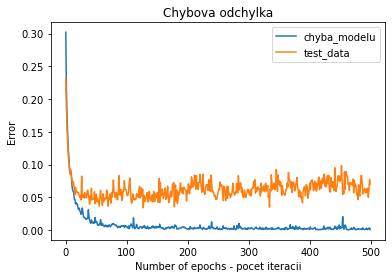

Najmensia chyba modelu: 0.00011482974514365196
Najmensia validacna chyba: 0.033946629613637924


In [9]:
# nacitanie vystupu z modelu do dataframu
output_df = pd.DataFrame(output.history)

plt.figure(1)
plt.title('Chybova odchylka')
# porovnanie natrenovaneho modelu s testovacimi datami, ktore este nevidel
plt.plot(output_df.loc[:,['loss']],label = 'chyba_modelu')
plt.plot(output_df.loc[:,['val_loss']],label = 'test_data')
plt.xlabel('Number of epochs - pocet iteracii')
plt.ylabel('Error')

plt.legend()
plt.show()

print(f"Najmensia chyba modelu: {output_df['loss'].min()}")
print(f"Najmensia validacna chyba: {output_df['val_loss'].min()}") # Validacna chyba indikuje presnost na datach ktore model este nevidel teda sa jedna o ciastkove testovacie data

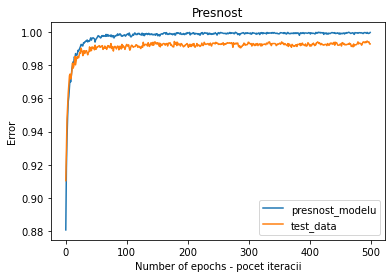

Najvacsia presnost modelu: 1.0
Najvacsia validacna presnost: 0.9946969747543335


In [10]:
plt.figure(2)
plt.title('Presnost')
# porovnanie natrenovaneho modelu s testovacimi datami, ktore este nevidel
plt.plot(output_df.loc[:,['binary_accuracy']],label = 'presnost_modelu')
plt.plot(output_df.loc[:,['val_binary_accuracy']],label = 'test_data')
plt.xlabel('Number of epochs - pocet iteracii')
plt.ylabel('Error')

plt.legend()
plt.show()

print(f"Najvacsia presnost modelu: {output_df['binary_accuracy'].max()}")
print(f"Najvacsia validacna presnost: {output_df['val_binary_accuracy'].max()}")

In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 190)               18240     
_________________________________________________________________
dropout (Dropout)            (None, 190)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 190)               36290     
_________________________________________________________________
dropout_1 (Dropout)          (None, 190)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 191       
Total params: 54,721
Trainable params: 54,721
Non-trainable params: 0
_________________________________________________________________
None


#  Testing model on test data

In [12]:
# funkcia predict zmeni hodnoty v X-ovej premmennej podla toho ci sa priblizuju k 0 alebo 1
preds = model.predict(x_test)

scores = model.evaluate(x_test, y_test)

124/124 [==============================] - 0s 447us/step - loss: 0.0699 - binary_accuracy: 0.9929


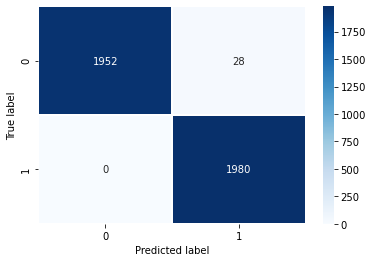

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1980
           1       0.99      1.00      0.99      1980

    accuracy                           0.99      3960
   macro avg       0.99      0.99      0.99      3960
weighted avg       0.99      0.99      0.99      3960



In [13]:
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix

data = confusion_matrix(y_test, preds.round())

sns.heatmap(data, linewidth=0.5, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

print(classification_report(y_test,preds.round()))